# active inference model of agency task
## complex version with changed context that's being inferred by agent

#### prerequisites

In [1]:
# !pip install inferactively-pymdp
import os
import sys
import pathlib
import numpy as np 
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import pymdp

from pymdp import utils 
from pymdp import maths
from pymdp.maths import softmax
from pymdp.agent import Agent


### THE GENERATIVE MODEL

#### specifying the states and observations

In [2]:
""" Defining state factors """
self_context_names = ['self_positivecontrol', 'self_negativecontrol', 'self_zerocontrol']
other_context_names = ['other_positivecontrol', 'other_negativecontrol', 'other_zerocontrol']
self_action_names = ['self_null', 'self_buttonpress', 'self_buttonnotpress']
other_action_names = ['other_null', 'other_buttonpress', 'other_buttonnotpress']

""" Defining number of state factors and states """
num_states = [len(self_context_names), len(other_context_names), len(self_action_names), len(other_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_self_context_names = ['no_changes']
choice_other_context_names = ['no_changes']
choice_self_action_names = ['self_null', 'self_pressbutton', 'self_notpressbutton']
choice_other_action_names = ['equal_distribution']

""" Defining number of control states """
num_controls = [len(choice_self_context_names), len(choice_other_context_names), 
                len(choice_self_action_names), len(choice_other_action_names)]

""" Defining observational modalities """
obs_outcome_names = ['outcome_null','outcome_present', 'outcome_absent']
obs_choice_self_names = ['self_null', 'self_buttonpress', 'self_buttonnotpress']
obs_choice_other_names = ['other_null', 'other_buttonpress', 'other_buttonnotpress']

""" Defining number of observational modalities and observations """
num_obs = [len(obs_outcome_names), len(obs_choice_self_names), len(obs_choice_other_names)]
num_modalities = len(num_obs)

def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

#### likelihood (A) tensors

In [3]:
def create_A(p_outcome):
    
    A = utils.obj_array(len(num_obs))
    
    ''' A matrix for outcome '''
    A_outcome = np.zeros( (len(obs_outcome_names), len(self_context_names), 
                           len(other_context_names), len(self_action_names), len(other_action_names)) )
    
    # p(outcome_null | self_null)
    A_outcome[0,:,:,0,:] = 1.0

    # p(outcome_null | other_null)
    A_outcome[0,:,:,:,0] = 1.0
    
    # SELF_POS, OTHER_POS
    
    # p(outcome | self_pos, other_pos, self_press, other_press)
    #                            pre  abs
    A_outcome[:,0,0,1,1] = [0.0, 1.0, 0.0]
    
    # p(outcome | self_pos, other_pos, self_notpress, other_press)
    #                            pre  abs
    A_outcome[:,0,0,2,1] = [0.0, 0.5, 0.5]
    
    # p(outcome | self_pos, other_pos, self_press, other_notpress)
    #                            pre  abs
    A_outcome[:,0,0,1,2] = [0.0, 0.5, 0.5]
    
    # p(outcome | self_pos, other_pos, self_notpress, other_notpress)
    #                            pre  abs
    A_outcome[:,0,0,2,2] = [0.0, 0.0, 1.0]
    
    # SELF_POS, OTHER_NEG
    
    # p(outcome | self_pos, other_neg, self_press, other_press)
    #                            pre  abs
    A_outcome[:,0,1,1,1] = [0.0, 0.5, 0.5]
    
    # p(outcome | self_pos, other_neg, self_notpress, other_press)
    #                            pre  abs
    A_outcome[:,0,1,2,1] = [0.0, 0.0, 1.0]
    
    # p(outcome | self_pos, other_neg, self_press, other_notpress)
    #                            pre  abs
    A_outcome[:,0,1,1,2] = [0.0, 1.0, 0.0]
    
    # p(outcome | self_pos, other_neg, self_notpress, other_notpress)
    #                            pre  abs
    A_outcome[:,0,1,2,2] = [0.0, 0.5, 0.5]
    
    # SELF_POS, OTHER_ZERO
    
    # p(outcome | self_pos, other_zero, self_press, other_press)
    #                            pre  abs
    A_outcome[:,0,2,1,1] = [0.0, 1.0, 0.0]
    
    # p(outcome | self_pos, other_zero, self_notpress, other_press)
    #                            pre  abs
    A_outcome[:,0,2,2,1] = [0.0, 0.0, 1.0]
    
    # p(outcome | self_pos, other_zero, self_press, other_notpress)
    #                            pre  abs
    A_outcome[:,0,2,1,2] = [0.0, 1.0, 0.0]
    
    # p(outcome | self_pos, other_zero, self_notpress, other_notpress)
    #                            pre  abs
    A_outcome[:,0,2,2,2] = [0.0, 0.0, 1.0]
    
    # SELF_NEG, OTHER_POS
    
    # p(outcome | self_neg, other_pos, self_press, other_press)
    #                            pre  abs
    A_outcome[:,1,0,1,1] = [0.0, 0.5, 0.5]
    
    # p(outcome | self_neg, other_pos, self_notpress, other_press)
    #                            pre  abs
    A_outcome[:,1,0,2,1] = [0.0, 1.0, 0.0]
    
    # p(outcome | self_neg, other_pos, self_press, other_notpress)
    #                            pre  abs
    A_outcome[:,1,0,1,2] = [0.0, 0.0, 1.0]
    
    # p(outcome | self_neg, other_pos, self_notpress, other_notpress)
    #                            pre  abs
    A_outcome[:,1,0,2,2] = [0.0, 0.5, 0.5]
    
    # SELF_NEG, OTHER_NEG
    
    # p(outcome | self_neg, other_neg, self_press, other_press)
    #                            pre  abs
    A_outcome[:,1,1,1,1] = [0.0, 0.0, 1.0]
    
    # p(outcome | self_neg, other_neg, self_notpress, other_press)
    #                            pre  abs
    A_outcome[:,1,1,2,1] = [0.0, 0.5, 0.5]
    
    # p(outcome | self_neg, other_neg, self_press, other_notpress)
    #                            pre  abs
    A_outcome[:,1,1,1,2] = [0.0, 0.5, 0.5]
    
    # p(outcome | self_neg, other_neg, self_notpress, other_notpress)
    #                            pre  abs
    A_outcome[:,1,1,2,2] = [0.0, 1.0, 0.0]
    
    # SELF_NEG, OTHER_ZERO
    
    # p(outcome | self_neg, other_zero, self_press, other_press)
    #                            pre  abs
    A_outcome[:,1,2,1,1] = [0.0, 0.0, 1.0]
    
    # p(outcome | self_neg, other_zero, self_notpress, other_press)
    #                            pre  abs
    A_outcome[:,1,2,2,1] = [0.0, 1.0, 0.0]
    
    # p(outcome | self_neg, other_zero, self_press, other_notpress)
    #                            pre  abs
    A_outcome[:,1,2,1,2] = [0.0, 0.0, 1.0]
    
    # p(outcome | self_neg, other_zero, self_notpress, other_notpress)
    #                            pre  abs
    A_outcome[:,1,2,2,2] = [0.0, 1.0, 0.0]
    
    
    # SELF_ZERO, OTHER_POS
    
    # p(outcome | self_zero, other_pos, self_press, other_press)
    #                            pre  abs
    A_outcome[:,2,0,1,1] = [0.0, 1.0, 0.0]
    
    # p(outcome | self_zero, other_pos, self_notpress, other_press)
    #                            pre  abs
    A_outcome[:,2,0,2,1] = [0.0, 1.0, 0.0]
    
    # p(outcome | self_zero, other_pos, self_press, other_notpress)
    #                            pre  abs
    A_outcome[:,2,0,1,2] = [0.0, 0.0, 1.0]
    
    # p(outcome | self_zero, other_pos, self_notpress, other_notpress)
    #                            pre  abs
    A_outcome[:,2,0,2,2] = [0.0, 0.0, 1.0]
    
    # SELF_ZERO, OTHER_NEG
    
    # p(outcome | self_zero, other_neg, self_press, other_press)
    #                            pre  abs
    A_outcome[:,2,1,1,1] = [0.0, 0.0, 1.0]
    
    # p(outcome | self_zero, other_neg, self_notpress, other_press)
    #                            pre  abs
    A_outcome[:,2,1,2,1] = [0.0, 0.0, 1.0]
    
    # p(outcome | self_zero, other_neg, self_press, other_notpress)
    #                            pre  abs
    A_outcome[:,2,1,1,2] = [0.0, 1.0, 0.0]
    
    # p(outcome | self_zero, other_neg, self_notpress, other_notpress)
    #                            pre  abs
    A_outcome[:,2,1,2,2] = [0.0, 1.0, 0.0]
    
    # SELF_ZERO, OTHER_ZERO
    
    # p(outcome | self_zero, other_zero, self_press, other_press)
    #                            pre  abs
    A_outcome[:,2,2,1,1] = [0.0, 0.5, 0.5]
    
    # p(outcome | self_zero, other_zero, self_notpress, other_press)
    #                            pre  abs
    A_outcome[:,2,2,2,1] = [0.0, 0.5, 0.5]
    
    # p(outcome | self_zero, other_zero, self_press, other_notpress)
    #                            pre  abs
    A_outcome[:,2,2,1,2] = [0.0, 0.5, 0.5]
    
    # p(outcome | self_zero, other_zero, self_notpress, other_notpress)
    #                            pre  abs
    A_outcome[:,2,2,2,2] = [0.0, 0.5, 0.5]
    
    
    ''' A matrix for proprioception '''
    A_choice_self = np.zeros((len(obs_choice_self_names), len(self_action_names)))
    
    A_choice_self = np.eye(len(self_action_names))
    
    ''' A matrix for observing other agent's actions '''
    A_choice_other = np.zeros((len(obs_choice_other_names), len(other_action_names)))
    
    A_choice_other = np.eye(len(other_action_names))
    
    ''' stacking up the A matrices '''
    A[0], A[1], A[2] = A_outcome, A_choice_self, A_choice_other
    A_factor_list = [[0,1,2,3], [2], [3]]
    
    A = utils.norm_dist_obj_arr(A)
    
    return A, A_factor_list

# printing matrices out for testing
A,A_factor_list = create_A(p_outcome = 1.0)

print("p(outcome|self_context, other_pos, self_null, other_press)")
print()
print(A[0][:,:,0,0,1]) 
print()
print("p(outcome|self_context, other_neg, self_press, other_press)")
print()
print(A[0][:,:,1,1,1]) 
print()
print("p(outcome|self_context, other_neg, self_press, other_notpress)")
print()
print(A[0][:,:,1,1,2]) 
print()
print("p(outcome|self_context, other_neg, self_notpress, other_press)")
print()
print(A[0][:,:,1,2,1]) 

#  s.p  s.n  s.z
# [[0.   0.   0.] outcome_null
#  [0.   0.   0.] outcome_present
#  [0.   0.   0.]] outcome_absent

p(outcome|self_context, other_pos, self_null, other_press)

[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]

p(outcome|self_context, other_neg, self_press, other_press)

[[0.  0.  0. ]
 [0.5 0.  0. ]
 [0.5 1.  1. ]]

p(outcome|self_context, other_neg, self_press, other_notpress)

[[0.  0.  0. ]
 [1.  0.5 1. ]
 [0.  0.5 0. ]]

p(outcome|self_context, other_neg, self_notpress, other_press)

[[0.  0.  0. ]
 [0.  0.5 0. ]
 [1.  0.5 1. ]]


#### state transition (B) tensors

In [4]:
def create_B():
    
    B = utils.initialize_empty_B(num_states, num_states)
    
    ''' B matrix for context regarding the self '''
    B_self_context = np.zeros( (len(self_context_names), len(self_context_names), len(choice_self_context_names)) )

#     B_self_context[:,:,0] = np.array(1.0/float(num_states[0]))
    B_self_context[:,:,0] = np.eye(len(self_context_names))
    
#     B_self_context = softmax(B_self_context)
    
    ''' B matrix for context regarding the other '''
    B_other_context = np.zeros( (len(other_context_names), len(other_context_names), len(choice_other_context_names)) )

#     B_other_context[:,:,0] = np.array(1.0/float(num_states[1]))
    B_other_context[:,:,0] = np.eye(len(other_context_names))
    
#     B_other_context = softmax(B_other_context)
    
    ''' B matrix for actions the self can make '''
    B_self_choice = np.zeros( (len(self_action_names), len(self_action_names), len(choice_self_action_names)) )
    
    for choice_id in range(len(self_action_names)):
        B_self_choice[choice_id, :, choice_id] = 1.0
    
    ''' B matrix for actions the other can make '''
    B_other_choice = np.zeros( (len(other_action_names), len(other_action_names), len(choice_other_action_names)) )
    
    B_other_choice[:,:,0] = np.array(1.0/float(num_states[3]))
    
    ''' stacking up the B matrices '''
    B[0], B[1], B[2], B[3] = B_self_context, B_other_context, B_self_choice, B_other_choice
    
    B = utils.norm_dist_obj_arr(B)
    
    return B

# B = create_B()
# print(B[0][:,:,0])

#### preferences (C) vectors

In [5]:
def create_C(outcomepref, actionpref, noactionpref):
        
    C = utils.obj_array_zeros(num_obs)
    C[0] = np.array([0.0, outcomepref, 0.0])
    C[1] = np.array([0.0, actionpref, noactionpref])
    C[2] = np.array([0.0, 0.0, 0.0])
    
    return C

# C = create_C(reward = 1.0, pun = 0.0)
# utils.plot_beliefs(softmax(C[0]), title = "Prior preferences for outcome_present and outcome_absent")

#### priors (D) vectors

In [6]:
def create_D():
    
    D = utils.obj_array(num_factors)
    
    D_self_context = np.ones(num_states[0])/float(num_states[0])
    
    D_other_context = np.ones(num_states[1])/float(num_states[1])
    
    D_self_choice = np.zeros(len(self_action_names)) 
    D_self_choice[self_action_names.index("self_null")] = 1.0
    
    D_other_choice = np.zeros(len(other_action_names)) 
    D_other_choice[other_action_names.index("other_null")] = 1.0

    D[0], D[1], D[2], D[3] = D_self_context, D_other_context, D_self_choice, D_other_choice
    
    return D

# D = create_D(p_context=1/float(num_states[0]))
# utils.plot_beliefs(softmax(D[1]), title = "Prior beliefs about probability of the contexts")

### THE GENERATIVE PROCESS

In [7]:
class AgencyTask(object):
    
    def __init__(self, expcondition = None , p_other_action = 0.5, p_outcome = 1.0):
        
        # defining the experimental conditions for the generative process
        self.expcondition_names = ['self_positivecontrol', 'self_negativecontrol', 
                                   'other_positivecontrol', 'other_negativecontrol', 
                                   'zerocontrol']
        self.num_expcondition = len(self.expcondition_names)
        
        if expcondition == None:
            self.expcondition = self.expcondition_names[utils.sample(np.ones(self.num_expcondition)/self.num_expcondition)] # randomly sample which context is selected
        else:
            self.expcondition = expcondition
            
        self.p_outcome = p_outcome
        self.p_other_action = p_other_action
        
        self.action_other_names = ['other_null', 'other_pressbutton', 'other_notpressbutton']
        self.obs_outcome_names = ['outcome_null', 'outcome_present', 'outcome_absent']
                
    def step(self, action):

        # sampling the other agent's actions at random (p(other_action) = 0.5)
        self.action_other = self.action_other_names[utils.sample(np.array([0.0, self.p_other_action, 1.0-self.p_other_action]))]
        
        if action == "self_null" and self.action_other == "other_null":
            observed_choice_self = "self_null"
            observed_choice_other = "other_null"
            observed_outcome = "outcome_null"
                
        elif action == "self_pressbutton" and self.action_other == "other_pressbutton":
            observed_choice_self = "self_buttonpress"
            observed_choice_other = "other_buttonpress"
            
            if self.expcondition == "self_positivecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "self_negativecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "other_positivecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "other_negativecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "zerocontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 0.5, 0.5]))]
                
        elif action == "self_pressbutton" and self.action_other == "other_notpressbutton":
            observed_choice_self = "self_buttonpress"
            observed_choice_other = "other_buttonnotpress"
            
            if self.expcondition == "self_positivecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "self_negativecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "other_positivecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "other_negativecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "zerocontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 0.5, 0.5]))]
                
        elif action == "self_notpressbutton" and self.action_other == "other_pressbutton":
            observed_choice_self = "self_buttonnotpress"
            observed_choice_other = "other_buttonpress"
            
            if self.expcondition == "self_positivecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "self_negativecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "other_positivecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "other_negativecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "zerocontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 0.5, 0.5]))]
                
        elif action == "self_notpressbutton" and self.action_other == "other_notpressbutton":
            observed_choice_self = "self_buttonnotpress"
            observed_choice_other = "other_buttonnotpress"
            
            if self.expcondition == "self_positivecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "self_negativecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "other_positivecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == "other_negativecontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == "zerocontrol":
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.0, 0.5, 0.5]))]

        obs = [observed_outcome, observed_choice_self, observed_choice_other]

        return obs

### RUNNING ACTIVE INFERENCE 

In [8]:
# def eval_policy(my_agent):
    
#     for idx, policy in enumerate(my_agent.policies):
    
#         qs_pi = get_expected_states(
#             my_agent.qs, my_agent.B, policy
#         )

#         qo_pi = get_expected_obs_factorized(
#             qs_pi, my_agent.A, my_agent.A_factor_list
#         )

#         e_u = calc_expected_utility(qo_pi, my_agent.C)

#         e_ig = calc_states_info_gain_factorized(
#             my_agent.A, qs_pi, my_agent.A_factor_list
#         )

#         EFE = e_u + e_ig

#         print(e_ig)



In [9]:
def run_active_inference_loop(my_agent, my_env, T, verbose):
    
    """ Initialize the first observation """
    obs_label = ["outcome_null", "self_null", "other_null"]  
    obs = [obs_outcome_names.index(obs_label[0]), obs_choice_self_names.index(obs_label[1]), obs_choice_other_names.index(obs_label[2])]
    
    first_choice = obs_choice_self_names.index(obs_label[1])
    choice_self_hist = np.zeros((num_controls[2],T+1))
    choice_self_hist[first_choice,0] = 1.0
    
    belief_self_context_hist = np.zeros((num_states[0], T))
    belief_other_context_hist = np.zeros((num_states[1], T))
    belief_self_action_hist = np.zeros((num_states[2], T))
    belief_other_action_hist = np.zeros((num_states[3], T))
    
    expcondition_hist = np.zeros(T)
    outcome_hist = np.zeros((num_obs[0],T))
    
    for t in range(T):
        
        expcondition_hist[t] = env.expcondition_names.index(env.expcondition)
        
        qs = my_agent.infer_states(obs)
        belief_self_context_hist[:,t] = qs[0]
        belief_other_context_hist[:,t] = qs[1]
        belief_self_action_hist[:,t] = qs[2]
        belief_other_action_hist[:,t] = qs[3]
        
        outcome_hist[obs[0],t] = 1.0
            
        q_pi, efe = my_agent.infer_policies_factorized()

        
        chosen_action_id = my_agent.sample_action()
        action_id = int(chosen_action_id[2])
        choice_self_hist[action_id,t+1]= 1.0
        choice_action = choice_self_action_names[action_id]
          
        obs_label = my_env.step(choice_action)
        obs = [obs_outcome_names.index(obs_label[0]), obs_choice_self_names.index(obs_label[1]), obs_choice_other_names.index(obs_label[2])]
        

        
    return choice_self_hist, belief_self_context_hist, belief_other_context_hist, expcondition_hist, belief_other_action_hist, outcome_hist

In [10]:
p_outcome_env = 1.0
p_other_action_env = 0.5

env = AgencyTask(p_other_action = p_other_action_env, p_outcome = p_outcome_env)

T = 20

A,A_factor_list = create_A(p_outcome = 1.0)
B = create_B()
C = create_C(outcomepref = 5.0, actionpref = 0.0, noactionpref = 0.05)
D = create_D()
my_agent = Agent(A=A, B=B, C=C, D=D, A_factor_list=A_factor_list)


choice_self_hist, belief_self_context_hist, belief_other_context_hist, expcondition_hist, belief_other_action_hist, outcome_hist = run_active_inference_loop(my_agent, env, T = T, verbose = False)

### PLOTTING 

In [11]:
def plot_some_choices_beliefs(choice_self_hist, belief_self_context_hist, belief_other_context_hist, pad_val=5.0):
    print(env.expcondition)
    
    T = choice_self_hist.shape[1]
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15,13))
    
    axes[0].imshow(choice_self_hist[:,:-1], cmap = 'gray') 
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(num_states[2]))
    axes[0].set_yticklabels(labels = choice_action_self_names)
    axes[0].set_title('Actions produced by the self over time')
    
    axes[1].imshow(belief_self_context_hist, cmap = 'gray')
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(num_states[0]))
    axes[1].set_yticklabels(labels = context_self_names)
    axes[1].set_title('Beliefs about control the self has over time')
    
    axes[2].imshow(belief_other_context_hist, cmap = 'gray')
    axes[2].set_xlabel('Timesteps')
    axes[2].set_yticks(ticks = range(num_states[1]))
    axes[2].set_yticklabels(labels = context_other_names)
    axes[2].set_title('Beliefs about control the other has over time')
    
    fig.tight_layout(pad=pad_val)
    plt.show()

In [12]:
def plot_all_choices_beliefs(choice_self_hist, belief_self_context_hist, belief_other_context_hist, expcondition_hist, belief_other_action_hist, outcome_hist, pad_val=1.0):
    
    print(f'Experimental Condition (or Context): {env.expcondition}')
    
    T = choice_self_hist.shape[1]
    fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (15,20))
    
    axes[0].imshow(belief_self_context_hist, cmap = 'gray')
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(num_states[0]))
    axes[0].set_yticklabels(labels = self_context_names)
    axes[0].set_title('Beliefs about control the self has over time')

    axes[1].imshow(belief_other_context_hist, cmap = 'gray')
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(num_states[1]))
    axes[1].set_yticklabels(labels = other_context_names)
    axes[1].set_title('Beliefs about control the other has over time')

    axes[2].imshow(choice_self_hist[:,:-1], cmap = 'gray') 
    axes[2].set_xlabel('Timesteps')
    axes[2].set_yticks(ticks = range(num_states[2]))
    axes[2].set_yticklabels(labels = self_action_names)
    axes[2].set_title('Actions produced by the self over time')
    
    axes[3].imshow(belief_other_action_hist[:,:-1], cmap = 'gray') 
    axes[3].set_xlabel('Timesteps')
    axes[3].set_yticks(ticks = range(num_states[3]))
    axes[3].set_yticklabels(labels = other_action_names)
    axes[3].set_title('Beliefs about actions produced by the other over time')

    axes[4].imshow(outcome_hist[:,:-1], cmap = 'gray') 
    axes[4].set_xlabel('Timesteps')
    axes[4].set_yticks(ticks = range(num_obs[0]))
    axes[4].set_yticklabels(labels = obs_outcome_names)
    axes[4].set_title('Outcomes observed over time')

    fig.tight_layout(pad=pad_val)
    plt.show()

In [13]:
# plot_some_choices_beliefs(choice_hist, belief_hist, context_hist)

Experimental Condition (or Context): self_positivecontrol


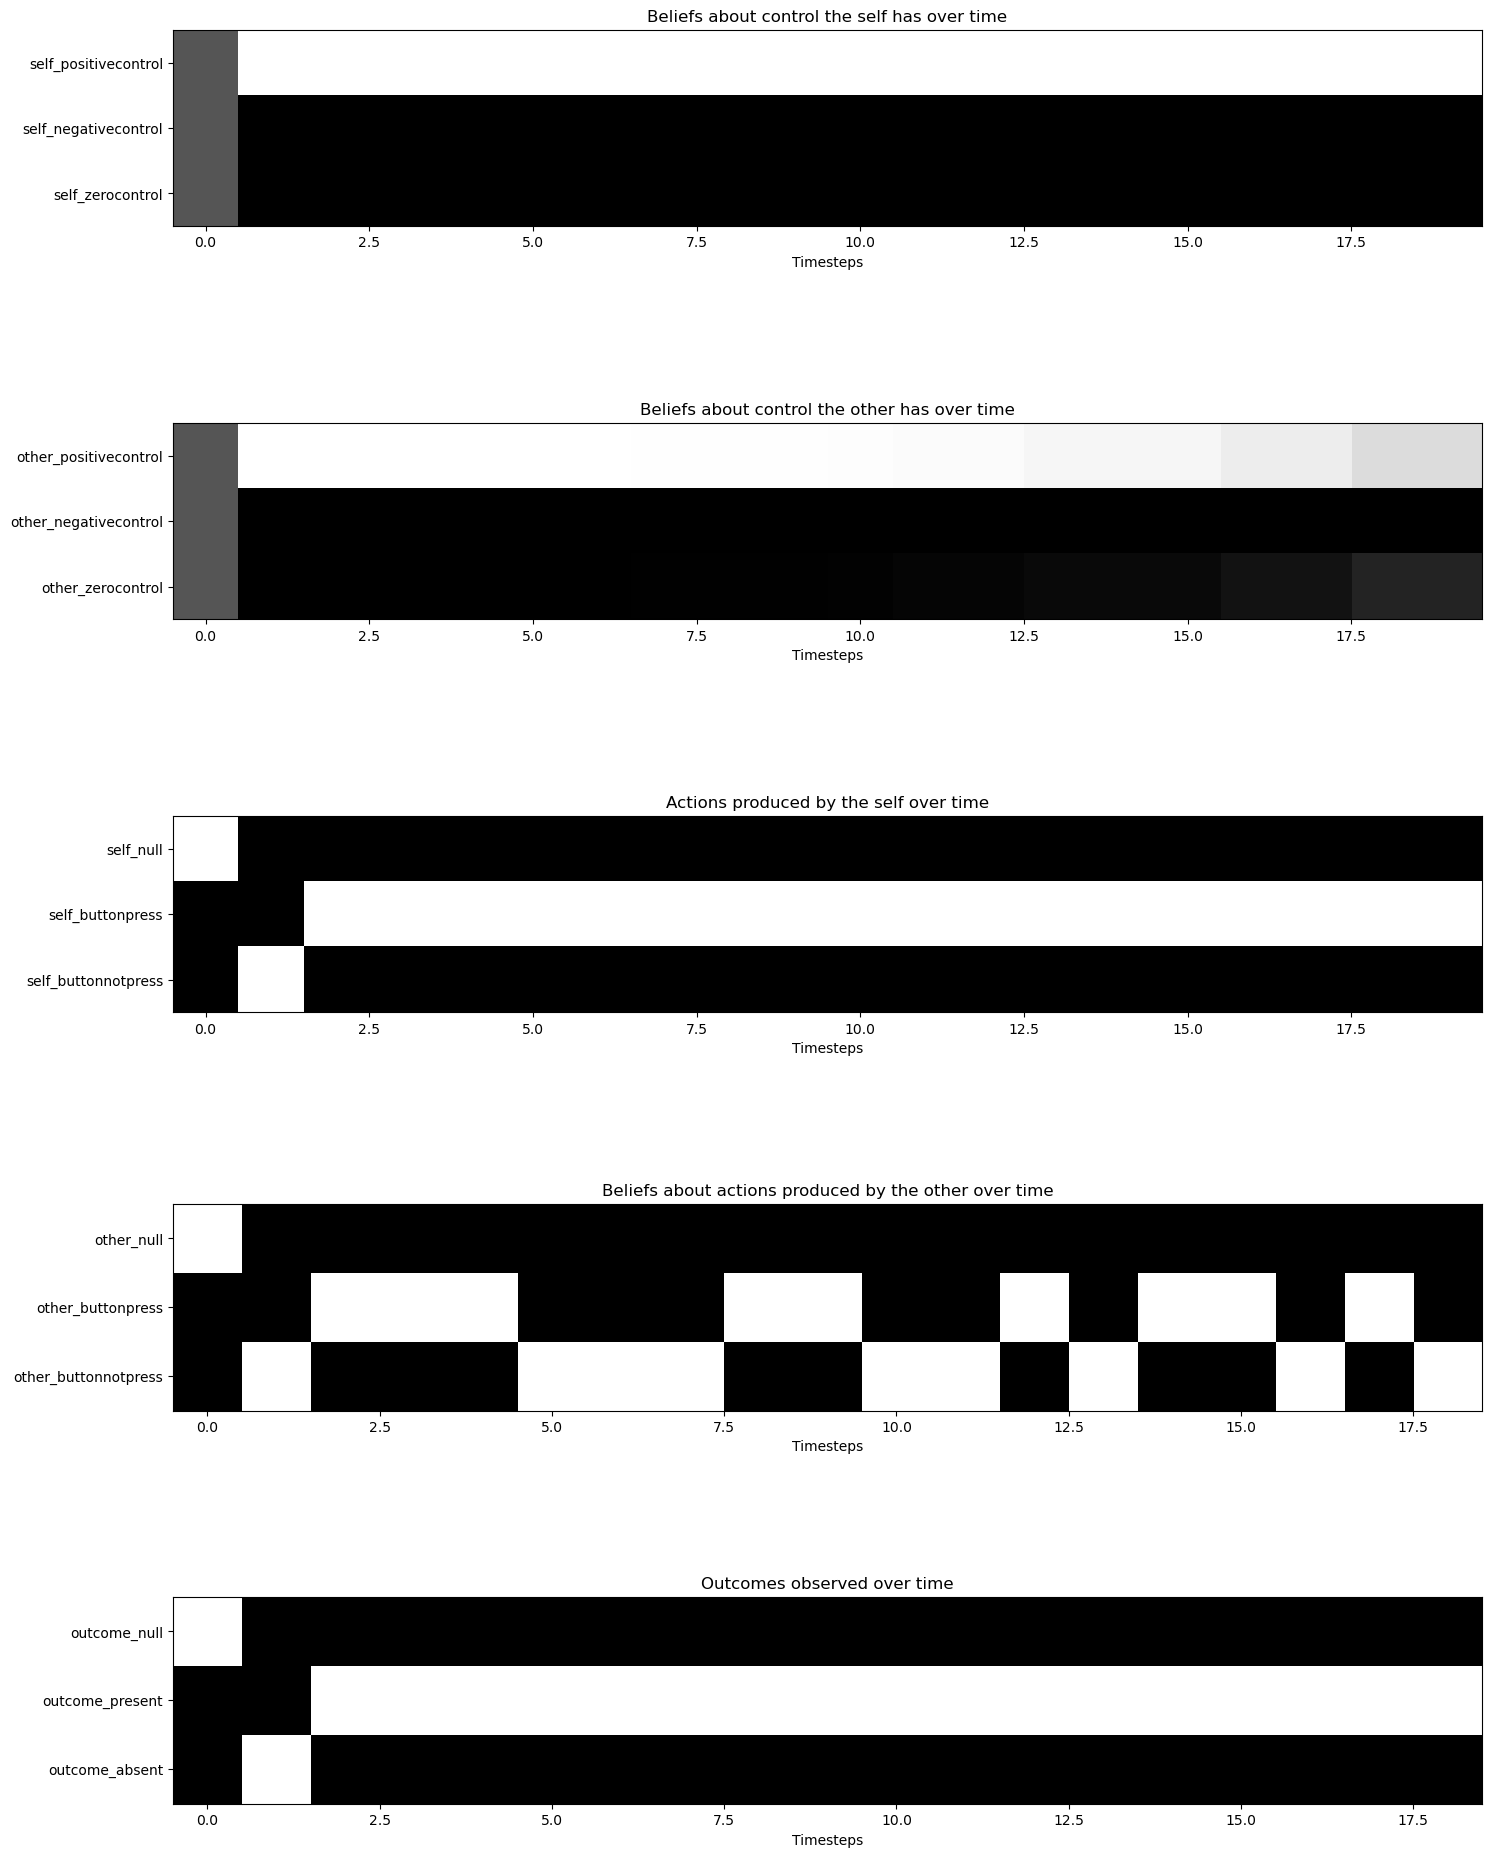

In [14]:
plot_all_choices_beliefs(choice_self_hist, belief_self_context_hist, belief_other_context_hist, expcondition_hist, belief_other_action_hist, outcome_hist)

In [15]:
# ''' TO PRINT INFO GAIN BASED ON POSTERIOR OF STATES IN A POLICY '''
# from pymdp.control import (
#         get_expected_states,
#         get_expected_obs_factorized,
#         calc_expected_utility,
#         calc_states_info_gain_factorized,
# )

# ''' in the run_ai_loop: '''      
#         eval_policy(my_agent)
##         infogain = my_agent.calc_states_info_gain_factorized()
#         print(t)
#         print(q_pi.round(3))
#         print(efe.round(3))
#         print(infogain.round(3))